# Data Access 

Data scientists know that one of the biggest challenges they face is managing data. By delivering imagery that is sorted and structured ARD reduces the time needed to organize data. It also allows access tools to work in an automatic manner.

`ARDCollection`s have methods that can read (and then also write) windows of data. The software handles finding the intersecting images and reading the pixels for you so you don't have to spend time iterating through image tiles yourself.

## Deforestation Example

One of the Maxar ARD sample datasets covers deforestation over time near Rio. Looking at one of the tiles in QGIS revealed this dam creating a pond:

![rio_feature.png](assets/rio_feature.png)

We'd like to leverage ARD to see when this dam first appeared in the ARD tiles.

In QGIS we drew the red AOI and exported it as GeoJSON to use as bounds for our image chips.

First, let's import some libraries:

In [3]:
# ARDCollection to work with data
from max_ard import ARDCollection

# Fiona to load our AOI geometry from a GeoJSON file
import fiona

# Modules for displaying and writing images
import os
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

To get started, we'll create an `ARDCollection` of the Rio sample data.

_Note: because the sample data is in a public AWS S3 bucket, for a simpler setup we'll pass `public=True` to disable authentication._

We can see that there are 24 tiles, and they all cover the same ARD Grid tile: z19-300022033202.

In [4]:
collection = ARDCollection('s3://maxar-ard-samples/rio_deforestation', public=True)
collection.tiles

[<ARDTile of 105041000218BB00 at z19-300022033202>,
 <ARDTile of 1050410001B2E100 at z19-300022033202>,
 <ARDTile of 103001000AC5B000 at z19-300022033202>,
 <ARDTile of 103001000CB3FD00 at z19-300022033202>,
 <ARDTile of 103001001826FC00 at z19-300022033202>,
 <ARDTile of 1050410000818900 at z19-300022033202>,
 <ARDTile of 1050410002473100 at z19-300022033202>,
 <ARDTile of 10300100253F7900 at z19-300022033202>,
 <ARDTile of 1030010026C30800 at z19-300022033202>,
 <ARDTile of 10300100296ED400 at z19-300022033202>,
 <ARDTile of 10504100105F9E00 at z19-300022033202>,
 <ARDTile of 1030010044098C00 at z19-300022033202>,
 <ARDTile of 105001000A224100 at z19-300022033202>,
 <ARDTile of 105001000A3F3700 at z19-300022033202>,
 <ARDTile of 10500100108C6000 at z19-300022033202>,
 <ARDTile of 1050010010B6CE00 at z19-300022033202>,
 <ARDTile of 105001001583E900 at z19-300022033202>,
 <ARDTile of 103001009A654D00 at z19-300022033202>,
 <ARDTile of 103001009D8E0A00 at z19-300022033202>,
 <ARDTile of

In this case we have selected an AOI that is already in this tile, but what if this collection had tiles all over the globe? How would we know which tiles to open, and how do we read just the window we want?

ARDCollection objects have a method which does this all for you.

(If you run the next cell in a notebook you can read the docstring, but here it is for reference)

```
Signature: processing.read_windows(collection, geoms, src_proj=4326)
Docstring:
A generator for reading windows from overlapping tiles in an ARDCollection

Args:
    geoms: A geometry object, or a list of geometries, which can be:
        - shapely geometry objects
        - dicts that follow the Python Geometry Interface (GeoJSON-like)
        - GeoJSON feature-like dicts that have a 'geometry' key
        - a Fiona dataset reader
    src_proj: An EPSG identifier parseable by Proj4

Yields:
    Tuple of:
        ARDTile of tile
        Shapely polygon representing the bounds of the input geometry
            in the tile's UTM coordinate system
        a Reader function:

            reader(asset)

                Args:
                    asset(str): asset to read: `visual`, `pan`, or `ms`
                
                Returns:
                    numpy array of data covered by the returned geometry

Example:

geoms = [...]
for tile, geom, reader in read_windows(geoms):
    # can check tile.properties, or fetch tile.clouds
    # can check if `geom` intersects with clouds
    data = reader('visual')

```


In [5]:
# shows the docstring in a notebook
from max_ard import processing
?processing.read_windows

We'll need the AOI geometry from the GeoJSON file, so we'll open the file with `fiona`. `read_windows()` can work directly with a Fiona dataset reader so there's no need to open the file and parse out geometries. Note that while we've named this `chips`, there's only one polygon in this file.

In [6]:
chips = fiona.open('example-geojson/rio-chip.geojson')

`read_windows()` returns a generator that will return a tuple of the following for every intersecting ARD tile in the ARDCollection:

- the intersecting ARDTile object
- the input geometry, reprojected to the tile's UTM coordinate system
- a reader function: `reader(<asset name>)`

The reader function, when called with a name of the raster asset (`visual`, `pan`, or `ms`), will return a Numpy array of the window covering the bounds of the input geometry.

So in a very simple example, we'll loop through windows with `read_windows()` and the features read by Fiona. Then we'll use Rasterio's `show` method to plot the image:

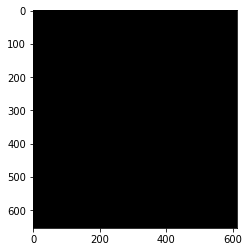

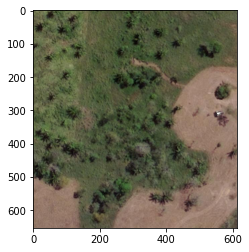

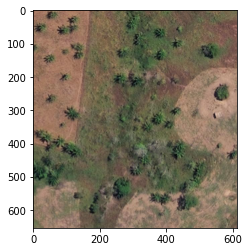

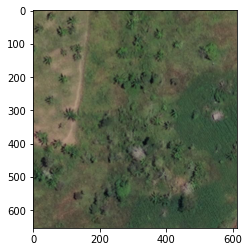

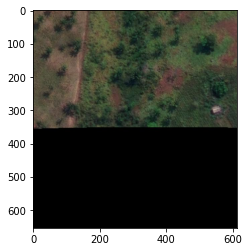

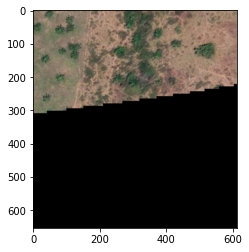

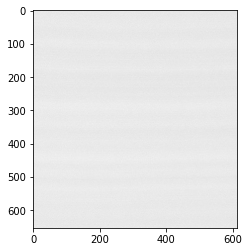

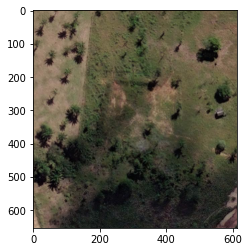

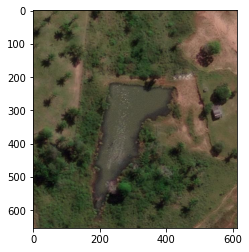

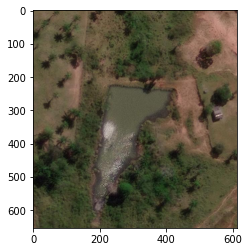

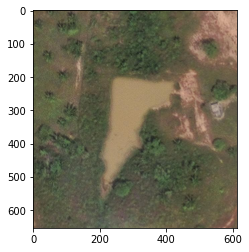

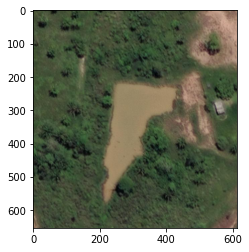

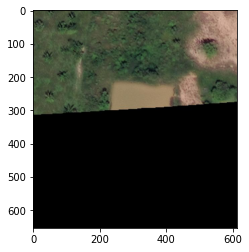

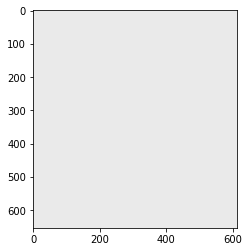

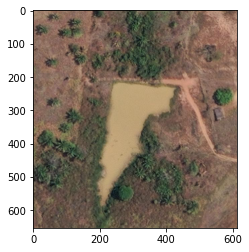

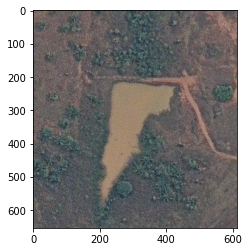

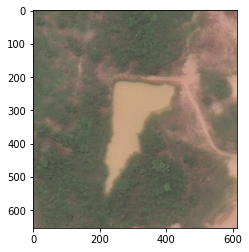

In [8]:
for tile, geom, reader in collection.read_windows(chips):
    # reader is a function, so you call it with the asset name
    show(reader('visual'))

If you scroll down through the tiles, you'll notice some of them are cut off or even empty of data, and some are covered in clouds.

Since `read_chips` also returns the projected chip geometry and an ARDTile object, we can do some checks to see if the chip intersects any of the vector ARD masks that are exposed as ARDtile attributes. If they do, we'll skip that tile.

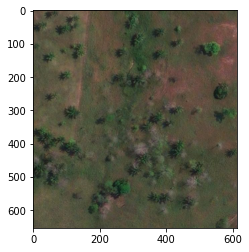

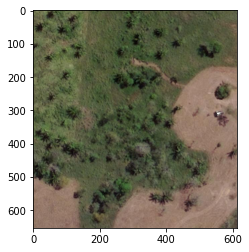

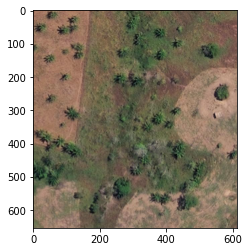

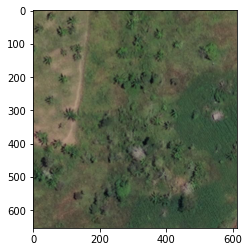

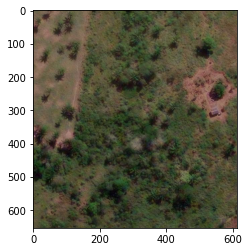

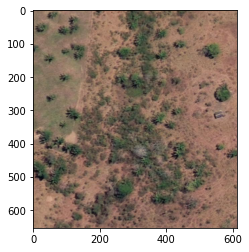

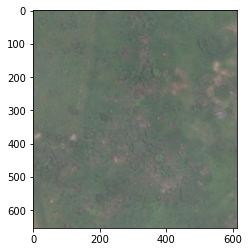

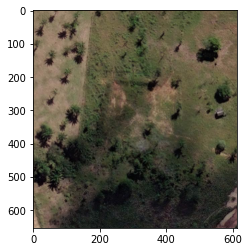

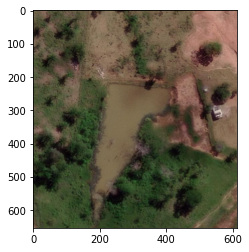

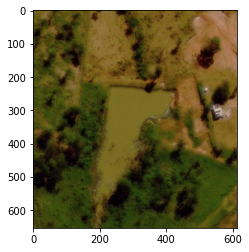

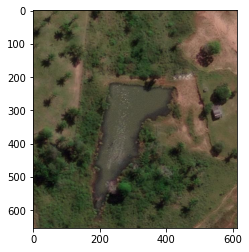

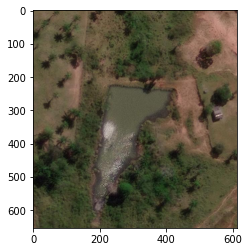

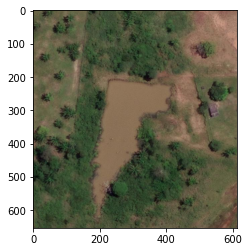

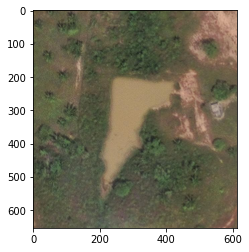

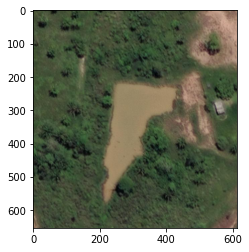

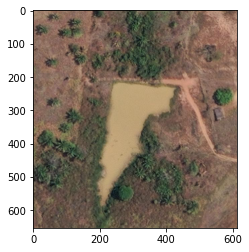

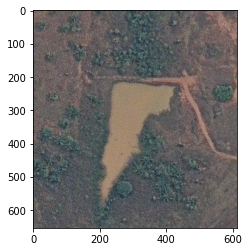

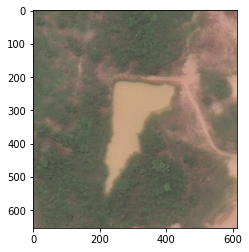

In [6]:
for tile, geom, reader in collection.read_windows(chips):
    # skip if the chip geometry intersects any clouds:
    if geom.intersects(tile.cloud_mask):
        continue
    # skip if the chip geometry intersects any nodata:
    if geom.intersects(tile.no_data_mask):
        continue
    show(reader('visual'))

While `show()` is an easy way to view the images, it would be much nicer to see them in grid labeled by date and without the axes labeled.

Let's create a nicer Matplotlib figure:

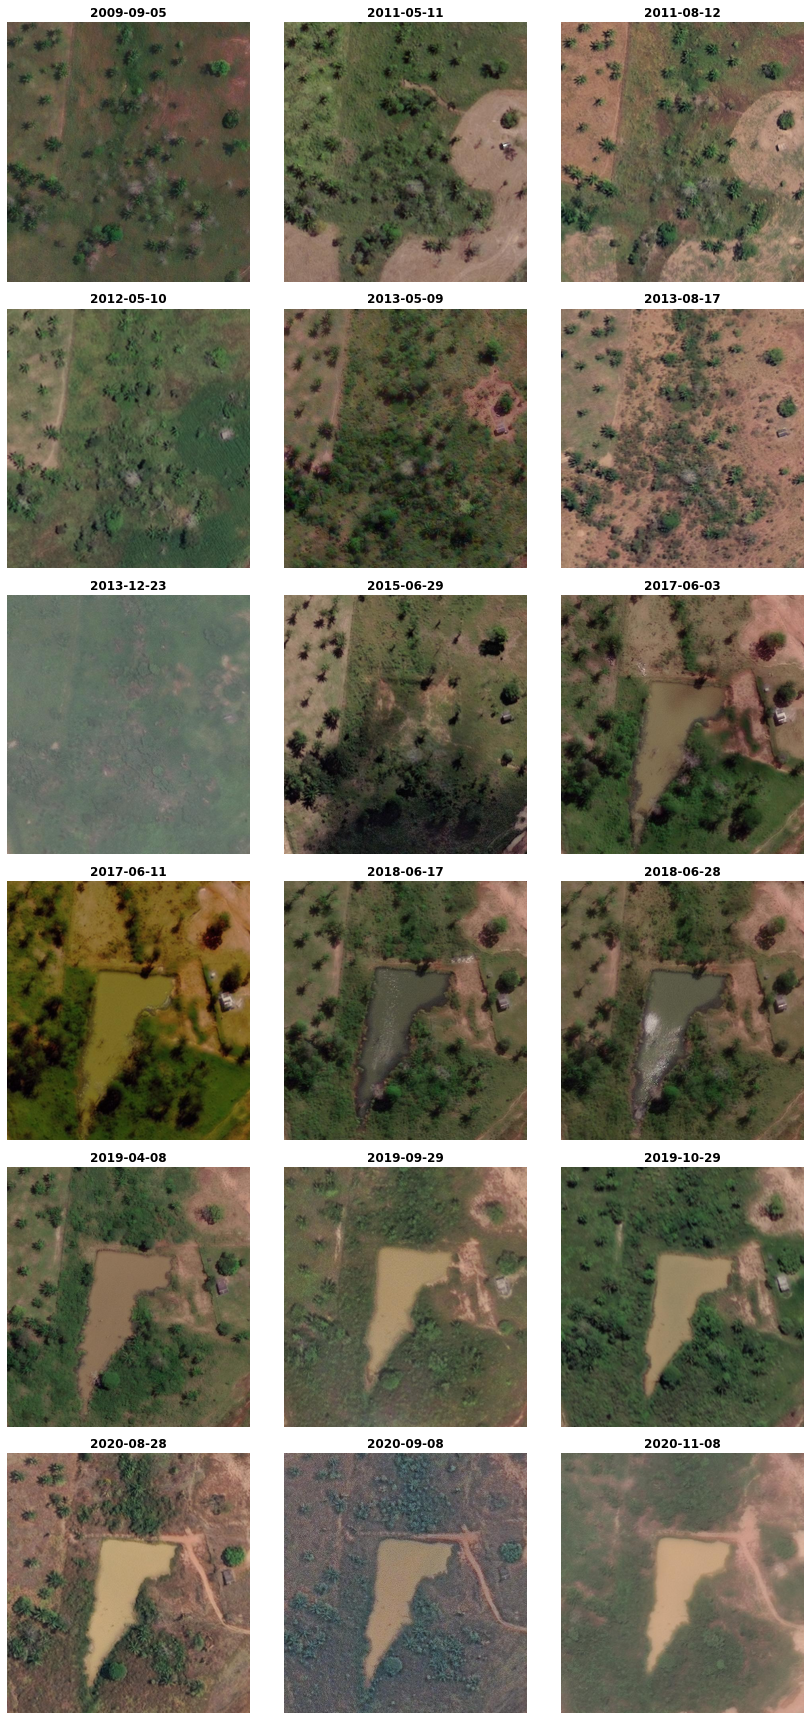

In [7]:
# set up a new figure
fig = plt.figure(figsize=(12,24))

# Loop through the windows as before
index = 1
for tile, geom, reader in collection.read_windows(chips):
    if geom.intersects(tile.cloud_mask):
        continue
    if geom.intersects(tile.no_data_mask):
        continue
        
    # Create a subplot
    ax = fig.add_subplot(6,3,index)
    ax.set_axis_off() # turn off the axes
    show(reader('visual'), ax=ax, title=tile.date) # add a title using the tile's date
    index += 1

# makes a nicer looking plot    
plt.tight_layout()

Like `read_windows()`, there is also a matching `write_windows()` that works in a similar way. Instead of a function you can call to read data, the generator returns a function that can be called to write the data.

```
writer(asset, path, **kwargs)

    Args:
        asset(str): asset to read: `visual`, `pan`, or `ms`
        path(str): path and name to write the file to.
        
    Kwargs: 
        driver(str): default is 'GTIFF', but can be 'JPEG' or any other support GDAL driver
        Additional keywords are passed to Rasterio's `open` method to create the output file.

    Returns:
        None
```


In [8]:
try:
    os.mkdir('./chips')
except:
    pass

for tile, geom, writer in collection.write_windows(chips):
    # filter
    if geom.intersects(tile.cloud_mask):
        continue
    if geom.intersects(tile.no_data_mask):
        continue
    
    # generate a name and path for the chip
    name = f'./chips/{tile.acq_id}-chip.jpg'
    
    # Call the writer function with the source asset name and the path for the chip.
    # Default behavior is to use the GTIFF driver but we'll write JPEGs instead
    
    writer('visual', name, driver='JPEG')
    
os.listdir('./chips')

['chip-19.tif',
 '105001000A3F3700-chip.jpg',
 '105041000218BB00-chip.jpg',
 'chip-18.tif',
 '103001000AC5B000-chip.jpg.aux.xml',
 'chip-0-1050410001B2E100.tif',
 '103001009A654D00-chip.jpg.aux.xml',
 '103001000AC5B000-chip.jpg',
 'chip-23.tif',
 '105001000A3F3700-chip.jpg.aux.xml',
 '103001000CB3FD00-chip.jpg.aux.xml',
 '10300100AC6F6800-chip.jpg',
 'chip-0-10504100105F9E00.tif',
 'chip-22.tif',
 'chip-0-10300100296ED400.tif',
 'chip-20.tif',
 '10300100253F7900-chip.jpg',
 'chip-0-1050010020C7EE00.tif',
 'chip-21.tif',
 '103001009D8E0A00-chip.jpg.aux.xml',
 '1030010044098C00-chip.jpg',
 '103001000CB3FD00-chip.jpg',
 'chip-0-105001000A3F3700.tif',
 'chip-0-103001009E4FAD00.tif',
 '103001009D8E0A00-chip.jpg',
 '1050010010B6CE00-chip.jpg.aux.xml',
 '105041000218BB00-chip.jpg.aux.xml',
 '10300100296ED400-chip.jpg.aux.xml',
 'chip-9.tif',
 'chip-8.tif',
 'chip-0-103001000CB3FD00.tif',
 'chip-0-105001000A224100.tif',
 'chip-0-105001001583E900.tif',
 '105001000A224100-chip.jpg',
 '1050410002

Putting this all together, a minimalist chipping example that writes chips with incrementally numbered names is:

In [9]:
collection = ARDCollection('s3://maxar-ard-samples/rio_deforestation', public="True")
chips = fiona.open('example-geojson/rio-chip.geojson') 

for index, (tile, geom, writer) in enumerate(collection.write_windows(chips)):
    name = f'./chips/chip-{index}.tif'
    writer('visual', name)

The window functions can handle a single geometry or an iterable of geometries for input. If you need a reference to the original geometry object, you can loop over the geometries outside the generator and feed them individually.

In [10]:
collection = ARDCollection('s3://maxar-ard-samples/rio_deforestation', public="True")
chips = fiona.open('example-geojson/rio-chip.geojson')

for chip in chips:
    for index, (tile, geom, writer) in enumerate(collection.write_windows(chip['geometry'])):
        name = './chips/chip-' + chip['id'] + '-' + tile.acq_id + '.tif'
        writer('visual', name)

### Reading outside tiles

`read_windows` and `write_windows` can handle if a window extends beyond the extent of an ARD tile. In this example over San Francisco we read a window that extends beyond the image apron of the tile on the left.

![sf-overlap.png](assets/sf-overlap.png)

When we plot the windows, we can see that they only contain data. 

In [11]:
collection = ARDCollection('s3://maxar-ard-samples/sample-001', public=True)
collection.tiles

[<ARDTile of 1030010052208D00 at z10-120020223023>,
 <ARDTile of 105001001659C000 at z10-120020223023>,
 <ARDTile of 1050010017603F00 at z10-120020223023>,
 <ARDTile of 1030010052208D00 at z10-120020223032>,
 <ARDTile of 105001001659C000 at z10-120020223032>,
 <ARDTile of 1050010017603F00 at z10-120020223032>]

In [12]:
chips = fiona.open('example-geojson/outside-sf.geojson')

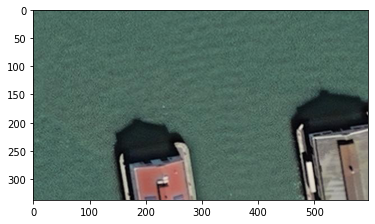

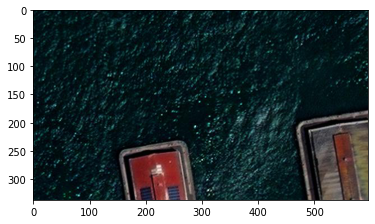

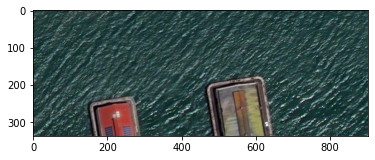

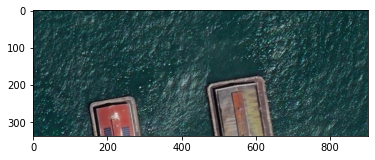

In [13]:
for tile, geom, reader in collection.read_windows(chips):
    # reader is a function, so you call it with the asset name
    show(reader('visual'))